In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import pickle
from sklearn import __version__ as sklearn_version
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime

In [2]:
wine_tasting = pd.read_csv('C:/Users/hamza/Downloads/Springboard Case Studies/Capstone Project 3/winemag-data-130k-v2.csv')

In [3]:
wine_tasting = wine_tasting.set_index('id')
wine_tasting.head(3)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
id,,,,,,,,,,,,,
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm


In [4]:
wine_tasting.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129971 entries, 0 to 129970
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                129908 non-null  object 
 1   description            129971 non-null  object 
 2   designation            92506 non-null   object 
 3   points                 129971 non-null  int64  
 4   price                  120975 non-null  float64
 5   province               129908 non-null  object 
 6   region_1               108724 non-null  object 
 7   region_2               50511 non-null   object 
 8   taster_name            103727 non-null  object 
 9   taster_twitter_handle  98758 non-null   object 
 10  title                  129971 non-null  object 
 11  variety                129970 non-null  object 
 12  winery                 129971 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 13.9+ MB


Categorical columns will next be converted to numerical ones for future modeling purposes.

In [5]:
wine_tasting["country"].value_counts()

US                        54504
France                    22093
Italy                     19540
Spain                      6645
Portugal                   5691
Chile                      4472
Argentina                  3800
Austria                    3345
Australia                  2329
Germany                    2165
New Zealand                1419
South Africa               1401
Israel                      505
Greece                      466
Canada                      257
Hungary                     146
Bulgaria                    141
Romania                     120
Uruguay                     109
Turkey                       90
Slovenia                     87
Georgia                      86
England                      74
Croatia                      73
Mexico                       70
Moldova                      59
Brazil                       52
Lebanon                      35
Morocco                      28
Peru                         16
Ukraine                      14
Serbia  

In [6]:
wine_tasting1 = wine_tasting.copy(deep=True)

counts = wine_tasting1["country"].value_counts()

mask = wine_tasting1["country"].isin(counts[counts<1000].index)
wine_tasting1["country"][mask] = 'Others w. count < 1000'
print(pd.value_counts(wine_tasting1["country"]))

US                        54504
France                    22093
Italy                     19540
Spain                      6645
Portugal                   5691
Chile                      4472
Argentina                  3800
Austria                    3345
Others w. count < 1000     2504
Australia                  2329
Germany                    2165
New Zealand                1419
South Africa               1401
Name: country, dtype: int64


<ipython-input-6-b507574f1eb2>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wine_tasting1["country"][mask] = 'Others w. count < 1000'


In [7]:
from sklearn import preprocessing
wine_tasting1 = wine_tasting1.dropna(subset=['country'])

In [8]:
wine_tasting1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129908 entries, 0 to 129970
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                129908 non-null  object 
 1   description            129908 non-null  object 
 2   designation            92454 non-null   object 
 3   points                 129908 non-null  int64  
 4   price                  120916 non-null  float64
 5   province               129908 non-null  object 
 6   region_1               108724 non-null  object 
 7   region_2               50511 non-null   object 
 8   taster_name            103664 non-null  object 
 9   taster_twitter_handle  98695 non-null   object 
 10  title                  129908 non-null  object 
 11  variety                129907 non-null  object 
 12  winery                 129908 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 13.9+ MB


Will now check number of unique categorical values in each column that are of value (i.e. descriptions are all bpund to be different and isn't necessarily a predictor):

In [9]:
print(wine_tasting1.designation.unique(),wine_tasting1.province.unique(), 
      wine_tasting1.taster_name.unique(),wine_tasting1.variety.unique(),
      wine_tasting1.winery.unique())

['Vulkà Bianco' 'Avidagos' nan ...
 'Gimblett Gravels Merlot-Cabernet Sauvignon-Malbec' 'Irongate'
 'Lieu-dit Harth Cuvée Caroline'] ['Sicily & Sardinia' 'Douro' 'Oregon' 'Michigan' 'Northern Spain' 'Alsace'
 'Rheinhessen' 'California' 'Mosel' 'Other' 'Mendoza Province' 'Virginia'
 'Beaujolais' 'Colchagua Valley' 'Southern Italy' 'Maule Valley'
 'Bordeaux' 'Maipo Valley' 'Washington' 'Central Italy' 'Champagne'
 'Burgundy' 'South Australia' 'Tejo' 'Rapel Valley' 'Galicia'
 'France Other' 'Tuscany' 'Burgenland' 'New York' 'Leyda Valley'
 'Piedmont' 'Stellenbosch' 'Simonsberg-Stellenbosch' 'Walker Bay'
 'Alentejano' 'Central Spain' 'Southwest France' 'Aconcagua Valley'
 'Loncomilla Valley' 'Marlborough' 'Northeastern Italy'
 'Casablanca Valley' 'Veneto' 'Western Cape' 'Judean Hills' 'Alentejo'
 'Coastal Region' 'Rhône Valley' 'Galilee' 'Beira Atlantico' 'Tokaj'
 'Leithaberg' 'Santorini' 'Kremstal' 'Catalonia' 'Recas' "Hawke's Bay"
 'Curicó Valley' 'Limarí Valley' 'Colchagua Costa' 'Langu

In [10]:
print(wine_tasting1["designation"].value_counts(),
      wine_tasting1["province"].value_counts(),
      wine_tasting1["taster_name"].value_counts(),
      wine_tasting1["variety"].value_counts(),
      wine_tasting1["winery"].value_counts())

Reserve                           2006
Estate                            1321
Reserva                           1259
Riserva                            698
Estate Grown                       621
                                  ... 
Jean-Baptiste Kabinett               1
Lieu-Dit Harth - Cuvée Carolin       1
Eagle's Rock                         1
Masseria Surani Helios               1
Loner W10-a                          1
Name: designation, Length: 37951, dtype: int64 California                  36247
Washington                   8639
Bordeaux                     5941
Tuscany                      5897
Oregon                       5373
                            ...  
Casablanca-Curicó Valley        1
Monemvasia                      1
Coelemu                         1
Urla-Thrace                     1
Imathia                         1
Name: province, Length: 425, dtype: int64 Roger Voss            25512
Michael Schachner     15127
Kerin O’Keefe         10776
Virginie Boone         9

In [11]:
d_counts = wine_tasting1["designation"].value_counts()
d_mask = wine_tasting1["designation"].isin(d_counts[d_counts<50].index)
wine_tasting1["designation"][d_mask] = 'Others w. count < 50'

p_counts = wine_tasting1["province"].value_counts()
p_mask = wine_tasting1["province"].isin(p_counts[p_counts<2000].index)
wine_tasting1["province"][p_mask] = 'Others w. count <2000'

t_counts = wine_tasting1["taster_name"].value_counts()
t_mask = wine_tasting1["taster_name"].isin(t_counts[t_counts<1000].index)
wine_tasting1["taster_name"][t_mask] = 'Others w. count <  1000'

v_counts = wine_tasting1["variety"].value_counts()
v_mask = wine_tasting1["variety"].isin(v_counts[v_counts<2000].index)
wine_tasting1["variety"][v_mask] = 'Others w. count< 2000'

w_counts = wine_tasting1["winery"].value_counts()
w_mask = wine_tasting1["winery"].isin(w_counts[w_counts<120].index)
wine_tasting1["winery"][w_mask] = 'Others w. count < 120'

r_counts = wine_tasting1["region_1"].value_counts()
r_mask = wine_tasting1["region_1"].isin(r_counts[r_counts<1100].index)
wine_tasting1["region_1"][r_mask] = 'Others w. count < 1100'

print(pd.value_counts(wine_tasting1["designation"]),
      pd.value_counts(wine_tasting1["province"]),
     pd.value_counts(wine_tasting1["taster_name"]),
     pd.value_counts(wine_tasting1["variety"]),
     pd.value_counts(wine_tasting1["winery"]),
     pd.value_counts(wine_tasting1["region_1"]))

Others w. count < 50    78828
Reserve                  2006
Estate                   1321
Reserva                  1259
Riserva                   698
                        ...  
Bacigalupi Vineyard        54
Rosé Brut                  52
Paragon Vineyard           52
Boushey Vineyard           50
Blanc de Noirs             50
Name: designation, Length: 65, dtype: int64 Others w. count <2000    43005
California               36247
Washington                8639
Bordeaux                  5941
Tuscany                   5897
Oregon                    5373
Burgundy                  3980
Northern Spain            3851
Piedmont                  3729
Mendoza Province          3264
Veneto                    2716
New York                  2688
Alsace                    2440
Northeastern Italy        2138
Name: province, dtype: int64 Roger Voss                 25512
Michael Schachner          15127
Kerin O’Keefe              10776
Virginie Boone              9537
Paul Gregutt                953

In [12]:
wine_tasting1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129908 entries, 0 to 129970
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                129908 non-null  object 
 1   description            129908 non-null  object 
 2   designation            92454 non-null   object 
 3   points                 129908 non-null  int64  
 4   price                  120916 non-null  float64
 5   province               129908 non-null  object 
 6   region_1               108724 non-null  object 
 7   region_2               50511 non-null   object 
 8   taster_name            103664 non-null  object 
 9   taster_twitter_handle  98695 non-null   object 
 10  title                  129908 non-null  object 
 11  variety                129907 non-null  object 
 12  winery                 129908 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 13.9+ MB


Dropping columns that are not hugely important in my opinion in answering the questions needed.

In [13]:
wine_tasting1 = wine_tasting1.drop(["designation", "region_2", "taster_twitter_handle","variety",'title'],
                                   axis=1)

In [14]:
wine_tasting1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129908 entries, 0 to 129970
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   country      129908 non-null  object 
 1   description  129908 non-null  object 
 2   points       129908 non-null  int64  
 3   price        120916 non-null  float64
 4   province     129908 non-null  object 
 5   region_1     108724 non-null  object 
 6   taster_name  103664 non-null  object 
 7   winery       129908 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 8.9+ MB


In [15]:
#Use below to not drop column but replace NaN rows with a constant value for missing values
wine_tasting1['region_1'] = wine_tasting1['region_1'].fillna('Not Available')
wine_tasting1['taster_name'] = wine_tasting1['taster_name'].fillna('Not Available')
wine_tasting1['price'] = wine_tasting1['price'].fillna(wine_tasting1['price'].median())

Now the columns on this table are more processable and trainable.

In [16]:
prov_price = wine_tasting1.groupby(
    wine_tasting1.province)['price'].mean().reset_index(name='average_price')
prov_price = prov_price.sort_values('average_price', ascending=False)
print(prov_price)

                 province  average_price
2                Burgundy      60.943970
10               Piedmont      49.815768
11                Tuscany      44.725623
3              California      38.985654
8                  Oregon      36.514982
1                Bordeaux      34.371318
12                 Veneto      32.677467
13             Washington      32.388239
7          Northern Spain      30.690989
0                  Alsace      29.731148
9   Others w. count <2000      28.738496
6      Northeastern Italy      26.902245
4        Mendoza Province      25.052696
5                New York      22.835938


The average price per profit is listed above. Champagne is the highest average price, perhaps indicative as to why the region has a drink named after it.

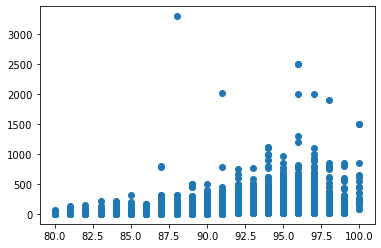

In [17]:
plt.scatter(wine_tasting1.points, wine_tasting1.price)
plt.show()

There is a moderate strength positive liner relationship between points and prices.

In [18]:
correlation_wine_tasting = wine_tasting1.corr()
print(correlation_wine_tasting)

          points     price
points  1.000000  0.399266
price   0.399266  1.000000


The above describes the strength of the correlation, positive, but moderate strength.

In [19]:
wine_tasting1.points.max()

100

In [20]:
conditions = [(wine_tasting1['points'] <84), (wine_tasting1['points'] >=90)]

# create a list of the values we want to assign for each condition
values = ['Below avg.', 'Above avg.']

# create a new column and use np.select to assign values to it using our lists as arguments
wine_tasting1['Over/above_avg.?'] = np.select(conditions, values)

wine_tasting1['Over/above_avg.?'].value_counts()

0             74935
Above avg.    49025
Below avg.     5948
Name: Over/above_avg.?, dtype: int64

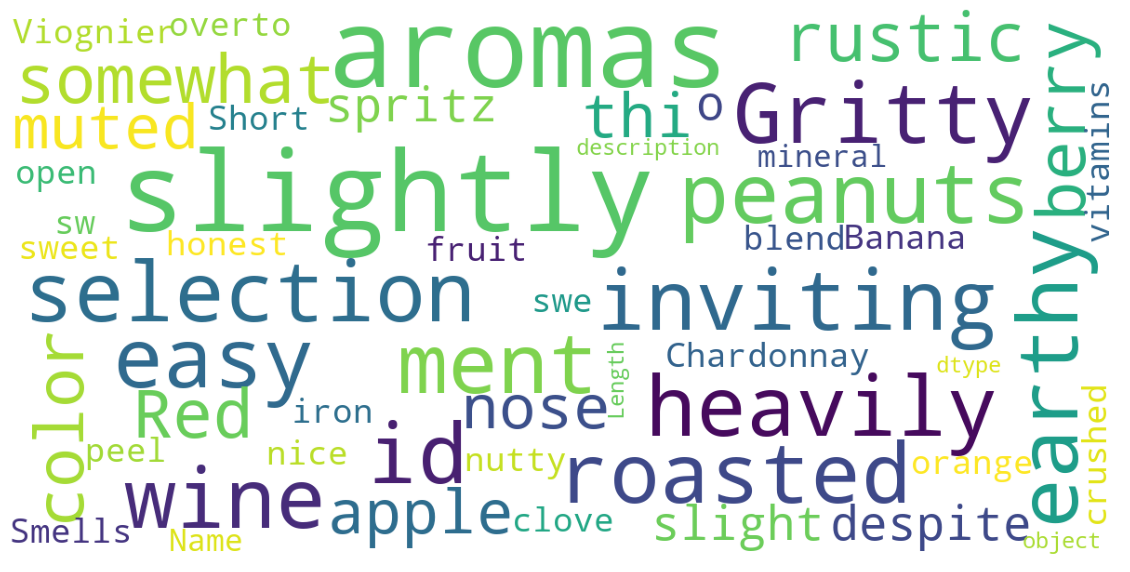

In [21]:
neg_words_wine_tasting1 = wine_tasting1[
    (wine_tasting1['Over/above_avg.?']=='Below avg.')]

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(neg_words_wine_tasting1["description"])

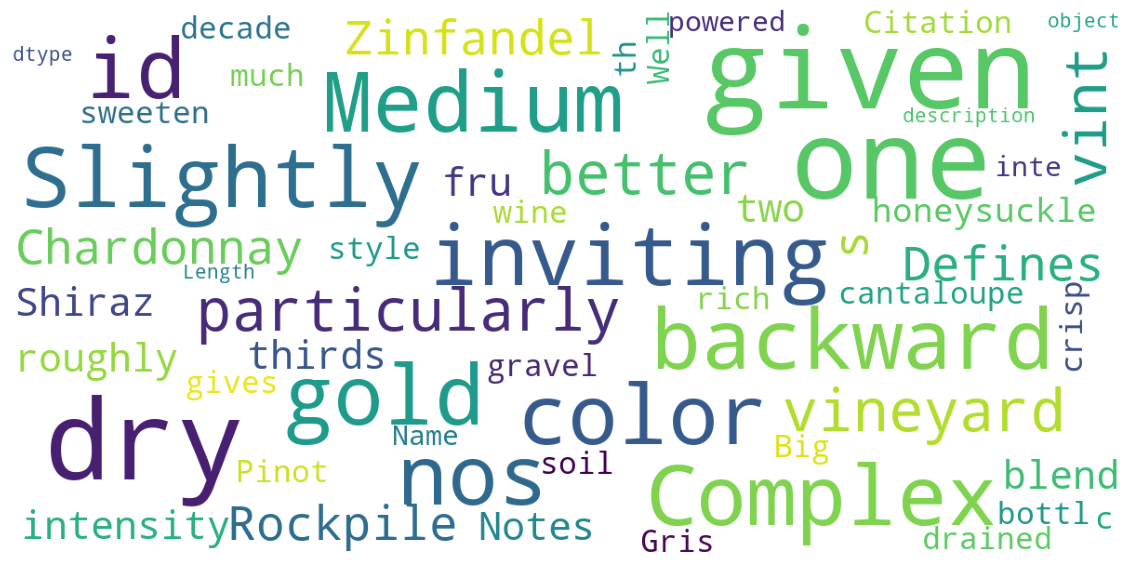

In [22]:
pos_words_wine_tasting1 = wine_tasting1[
    (wine_tasting1['Over/above_avg.?']=='Above avg.')]

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(pos_words_wine_tasting1["description"])

The median and mean were used to distinguish between negative and positive feedback (those below and above threshold) --- however the values were changed to reflect more closely what the negative and positive feedback thresholds are.

Now the description will be removed as it does not lend any value to the test_train split as a column with categorical and string values

In [23]:
wine_tasting1 = wine_tasting1.drop(["description"],
                                   axis=1)

**Next, the data will be partitioned into training & testing splits, without letting a model (or missing-value imputation) learn about the test split, getting a somewhat independent assessment of how the model might perform in the future.**

**Next will be assessing what partition sizes would be gotten from a 70/30 train/test split.**

In [24]:
wine_tasting1['Over/above_avg.?'].unique()

array(['0', 'Above avg.', 'Below avg.'], dtype=object)

In [25]:
wine_tasting2 = wine_tasting1.copy(deep=True)

wine_tasting2 = pd.get_dummies(data=wine_tasting2, columns=['country','province', 'region_1','taster_name', 
                                 'winery', 'Over/above_avg.?'])

wine_tasting2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129908 entries, 0 to 129970
Data columns (total 78 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   points                               129908 non-null  int64  
 1   price                                129908 non-null  float64
 2   country_Argentina                    129908 non-null  uint8  
 3   country_Australia                    129908 non-null  uint8  
 4   country_Austria                      129908 non-null  uint8  
 5   country_Chile                        129908 non-null  uint8  
 6   country_France                       129908 non-null  uint8  
 7   country_Germany                      129908 non-null  uint8  
 8   country_Italy                        129908 non-null  uint8  
 9   country_New Zealand                  129908 non-null  uint8  
 10  country_Others w. count < 1000       129908 non-null  uint8  
 11  country_Portu

In [26]:
len(wine_tasting2) * .7, len(wine_tasting2) * .3

(90935.59999999999, 38972.4)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(wine_tasting2.drop(columns='price'), 
                                                    wine_tasting2.price, test_size=0.3, 
                                                    random_state=47)

In [28]:
X_train.shape, X_test.shape

((90935, 77), (38973, 77))

In [29]:
y_train.shape, y_test.shape

((90935,), (38973,))

In [30]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90935 entries, 42162 to 103608
Data columns (total 77 columns):
 #   Column                               Non-Null Count  Dtype
---  ------                               --------------  -----
 0   points                               90935 non-null  int64
 1   country_Argentina                    90935 non-null  uint8
 2   country_Australia                    90935 non-null  uint8
 3   country_Austria                      90935 non-null  uint8
 4   country_Chile                        90935 non-null  uint8
 5   country_France                       90935 non-null  uint8
 6   country_Germany                      90935 non-null  uint8
 7   country_Italy                        90935 non-null  uint8
 8   country_New Zealand                  90935 non-null  uint8
 9   country_Others w. count < 1000       90935 non-null  uint8
 10  country_Portugal                     90935 non-null  uint8
 11  country_South Africa                 90935 non-nu

In [31]:
train_mean = y_train.mean()
train_mean

34.561972837741244

In [32]:
dumb_reg = DummyRegressor(strategy='mean')
dumb_reg.fit(X_train, y_train)
dumb_reg.constant_

array([[34.56197284]])

A good place to start is to see how good the mean is as a predictor. In other words, the best guess may be the average price. sklearn's DummyRegressor easily does this.

These closely match the actual values. There are many ways of assessing how good one set of values agrees with another.

Next up will be an assessment of the metrics. $R^2$, the coefficient of determination, will be used to predict whether we get a negative or positive answer, a positive answer meaning it perfectly predicts the observed values with no residual error ($R^2=1$). Models that do worse than predicting the mean will have increased the sum of squares of residuals and so produce a negative $R^2$.

In [33]:
y_tr_pred_ = train_mean * np.ones(len(y_train))
y_tr_pred_[:5]

array([34.56197284, 34.56197284, 34.56197284, 34.56197284, 34.56197284])

In [34]:
y_tr_pred = dumb_reg.predict(X_train)
y_tr_pred[:5]

array([34.56197284, 34.56197284, 34.56197284, 34.56197284, 34.56197284])

In [35]:
from sklearn.metrics import r2_score
r2_score(y_train, y_tr_pred)

0.0

In [36]:
y_te_pred = train_mean * np.ones(len(y_test))
r2_score(y_test, y_te_pred)

-5.885713578157592e-05

Generally, the performance on a test set is to be slightly worse than on the training set. After getting an $R^2$ of zero on the training set, there's nowhere to go but negative.

In [37]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error as mae


mae(y_train, y_tr_pred)

18.99435517746635

In [38]:
mae(y_test, y_te_pred)

19.277550622599797

In [39]:
def mse(y, ypred):
    """Mean square error  -  Calculate the mse of the arguments:
    y -- the observed values;      ypred -- the predicted values
    """
    sq_error = (y - ypred)**2
    mse = np.mean(sq_error)
    return mse

In [40]:
mse(y_train, y_tr_pred)

1608.0026227755204

In [41]:
mse(y_test, y_te_pred)

1494.4507986576664

So here, you get a slightly better MSE on the test set than you did on the train set. And what does a squared error mean anyway? To convert this back to our measurement space, we often take the square root, to form the root mean square error thus:

In [42]:
np.sqrt([mse(y_train, y_tr_pred), mse(y_test, y_te_pred)])

array([40.09990801, 38.6581272 ])

In [43]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.0, -5.885713578157592e-05)

In [44]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(18.99435517746635, 19.277550622599797)

In [45]:
mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)

(1608.002622775311, 1494.4507986574974)

In [46]:
r2_score(y_train, y_tr_pred), r2_score(y_tr_pred, y_train)

(0.0, -7.962443320037852e+30)

In [47]:
r2_score(y_test, y_te_pred), r2_score(y_te_pred, y_test)

(-5.885713578157592e-05, -2.9600647686402085e+31)

In [48]:
X_defaults_median = X_train.median()
X_defaults_median

points                         88.0
country_Argentina               0.0
country_Australia               0.0
country_Austria                 0.0
country_Chile                   0.0
                               ... 
winery_Williams Selyem          0.0
winery_Wines & Winemakers       0.0
Over/above_avg.?_0              1.0
Over/above_avg.?_Above avg.     0.0
Over/above_avg.?_Below avg.     0.0
Length: 77, dtype: float64

Apply the imputation to both train and test splits

In [49]:
X_tr = X_train.fillna(X_defaults_median)
X_te = X_test.fillna(X_defaults_median)

Scale the data

In [50]:
scaler = StandardScaler()
scaler.fit(X_tr)
X_tr_scaled = scaler.transform(X_tr)
X_te_scaled = scaler.transform(X_te)

Train the model on the train split

In [51]:
lm = LinearRegression().fit(X_tr_scaled, y_train)

Make predictions using the model on both train and test splits

In [52]:
y_tr_pred = lm.predict(X_tr_scaled)
y_te_pred = lm.predict(X_te_scaled)

Assess model performance

In [53]:
median_r2 = r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)
median_r2

(0.21342700886892907, 0.24517790217582702)

Recall estimating price by using a known average. As expected, this produced an $R^2$ of zero for the training & test set, because $R^2$ tells us how much of the variance is explained beyond using just the mean, and I was using just the mean. Here the simple linear regression model explains over 80% of the variance on the train set and over 55% on the test. The much lower value for the test set suggests overfitting. This isn't a surprise as I've made no effort to select a parsimonious set of features or deal with multicollinearity in data.

In [54]:
#Calculate mean absolute error scores using `sklearn`'s `mean_absolute_error` function
# as we did above for R^2; MAE - train, test
median_mae = mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)
median_mae

(15.20983548010214, 15.447666756907699)

Using this model, then, on average you'd expect to estimate a wine bottle price within $15 or so of the real price.

In [55]:
#Do the same using `sklearn`'s `mean_squared_error`; MSE - train, test
median_mse = mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)
median_mse

(1264.8114327429835, 1127.9780973776271)

Impute missing values with the mean:

Chose using the median for filling missing values because of the skew of many of our predictor feature distributions. If using the mean?

In [56]:
#Calculate mean values for imputing missing values. These are values to use to fill missing values
X_defaults_mean = X_train.mean()
X_defaults_mean

points                         88.443009
country_Argentina               0.029296
country_Australia               0.018046
country_Austria                 0.025854
country_Chile                   0.034640
                                 ...    
winery_Williams Selyem          0.001672
winery_Wines & Winemakers       0.001705
Over/above_avg.?_0              0.578974
Over/above_avg.?_Above avg.     0.376181
Over/above_avg.?_Below avg.     0.044845
Length: 77, dtype: float64

Apply the imputation to both train and test splits

In [57]:
X_tr = X_train.fillna(X_defaults_mean)
X_te = X_test.fillna(X_defaults_mean)

Scale the data

In [58]:
scaler = StandardScaler()
scaler.fit(X_tr)
X_tr_scaled = scaler.transform(X_tr)
X_te_scaled = scaler.transform(X_te)

Train the model on the train split

In [59]:
lm = LinearRegression().fit(X_tr_scaled, y_train)

Make predictions using the model on both train and test split

In [60]:
y_tr_pred = lm.predict(X_tr_scaled)
y_te_pred = lm.predict(X_te_scaled)

Assess model performance

In [61]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.21342700886892907, 0.24517790217582702)

In [62]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(15.20983548010214, 15.447666756907699)

In [63]:
mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)

(1264.8114327429835, 1127.9780973776271)

An important and useful components of sklearn is the pipeline. In place of panda's fillna DataFrame method, there is sklearn's SimpleImputer. Remember the first linear model above performed the steps:

replace missing values with the median for each feature
scale the data to zero mean and unit variance
train a linear regression model
and all these steps were trained on the train split and then applied to the test split for assessment.

The pipeline below defines exactly those same steps. Crucially, the resultant Pipeline object has a fit() method and a predict() method, just like the LinearRegression() object. As you might create a linear regression model and train it with .fit() and predict with .predict(), you can wrap the entire process of imputing and feature scaling and regression in a single object you can train with .fit() and predict with .predict(). A pipeline is a model on steroids.

In [64]:
pipe = make_pipeline(SimpleImputer(strategy='median'), 
    StandardScaler(), 
    LinearRegression())

In [65]:
type(pipe)

sklearn.pipeline.Pipeline

In [66]:
hasattr(pipe, 'fit'), hasattr(pipe, 'predict')

(True, True)

Here, a single call to the pipeline's fit() method combines steps of learning imputation (determining what values to use to fill missing ones), scaling (determining mean to subtract and variance to divide by), and then training the model. It does this all in the one call with training data as arguments.

In [67]:
#Call the pipe's `fit()` method with `X_train` and `y_train` as arguments
pipe.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

Make predictions on the train and test sets

In [68]:
y_tr_pred = pipe.predict(X_train)
y_te_pred = pipe.predict(X_test)

Assess performance

In [69]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.21342700886892907, 0.24517790217582702)

And compare with your earlier (non-pipeline) result:

In [70]:
median_r2

(0.21342700886892907, 0.24517790217582702)

In [71]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(15.20983548010214, 15.447666756907699)

Compare with your earlier result:

In [72]:
median_mae

(15.20983548010214, 15.447666756907699)

In [73]:
mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)

(1264.8114327429835, 1127.9780973776271)

In [74]:
median_mse

(1264.8114327429835, 1127.9780973776271)

The results confirm the pipeline is doing exactly what's expected, and results are identical to earlier steps. This allows us to move faster but with confidence.

Refining The Linear Model -- The model was overfitting, no real surprise given # of features used. sklearn has a number of feature selection functions available, starting with using SelectKBest (selects the k best features). f_regression is the score function used for performing regression.

Define the pipeline: Redefine your pipeline to include this feature selection step:

In [75]:
pipe = make_pipeline(SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(f_regression),
    LinearRegression())

Fit the pipeline

In [76]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(score_func=<function f_regression at 0x0000029CCD02DA60>)),
                ('linearregression', LinearRegression())])

Assess performance on the train and test set

In [77]:
y_tr_pred = pipe.predict(X_train)
y_te_pred = pipe.predict(X_test)

r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.19767830809448728, 0.22285696544439515)

In [78]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(15.530950058499416, 15.778445560344872)

Define a new pipeline to select a different number of features

In [79]:
#Modify the `SelectKBest` step to use a value of 15 for k
pipe15 = make_pipeline(SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(f_regression, k=10),
    LinearRegression())

Fit the pipeline

In [80]:
pipe15.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(score_func=<function f_regression at 0x0000029CCD02DA60>)),
                ('linearregression', LinearRegression())])

Assess performance on train and test data

In [81]:
y_tr_pred = pipe15.predict(X_train)
y_te_pred = pipe15.predict(X_test)
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.19767830809448728, 0.22285696544439515)

In [82]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(15.530950058499416, 15.778445560344872)

It is important to remember not to tune the model to the arbitrary test set. Otherwise, it may end up with a model that works well on the particular quirks of this test set but fails to generalize to new data. The point of keeping a test set is for it to be a set of that new data, to check how well the model performs on data it hasn't seen.

The way around this is a cross-validation. Partitioning the training set into k folds, training the model on k-1 of those folds, and calculating performance on the fold not used in training. This procedure then cycles through k times with a different fold held back each time. Thus ending up building k models on k sets of data with k estimates of how the model performs on unseen data but without having to touch the test set.

In [83]:
cv_results = cross_validate(pipe15, X_train, y_train, cv=5)

In [84]:
cv_scores = cv_results['test_score']
cv_scores

array([0.22323984, 0.24445975, 0.20348584, 0.13589439, 0.21716169])

Without using the same random state for initializing the CV folds, your actual numbers will be different.

In [85]:
np.mean(cv_scores), np.std(cv_scores)

(0.20484830310694954, 0.03692000386371816)

These results highlight that assessing model performance is inherently open to variability. You'll get different results depending on the quirks of which points are in which fold. An advantage of this is that you can also obtain an estimate of the variability, or uncertainty, in your performance estimate.

In [86]:
np.round((np.mean(cv_scores) - 2 * np.std(cv_scores), np.mean(cv_scores) + 2 * np.std(cv_scores)), 2)

array([0.13, 0.28])

Hyperparameter search using GridSearchCV: Pulling the above together, we have:

a pipeline that: imputes missing values, scales the data, selects the k best features, and trains a linear regression model.
a technique (cross-validation) for estimating model performance
Now to use cross-validation for multiple values of k and use cross-validation to pick the value of k that gives the best performance. make_pipeline automatically names each step as the lowercase name of the step and the parameters of the step are then accessed by appending a double underscore followed by the parameter name. Know the name of the step will be 'selectkbest' and know the parameter is 'k'.

List the names of all the parameters in a pipeline like this:

In [87]:
#Call `pipe`'s `get_params()` method to get a dict of available parameters and print their names
#using dict's `keys()` method
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'simpleimputer', 'standardscaler', 'selectkbest', 'linearregression', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'selectkbest__k', 'selectkbest__score_func', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__normalize', 'linearregression__positive'])

The above can be particularly useful as your pipelines becomes more complex (you can even nest pipelines within pipelines).

In [88]:
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}

There is a range of k to investigate. Is 1 feature best? 2? 3? All of them? I wrote a for loop and iterated over each possible value, doing all the housekeeping to track the best value of k. There's a built in function in sklearn, GridSearchCV. This takes the pipeline object, in fact it takes anything with a .fit() and .predict() method. In simple cases with no feature selection or imputation or feature scaling etc. may see the classifier or regressor object itself passed into GridSearchCV. The other key input is the parameters and values to search over. Optional parameters include the cross-validation strategy and number of CPUs to use.

In [89]:
lr_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [90]:
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x0000029CCD02DA60>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21, 22, 23, 24, 25, 26, 27, 28, 29,
                                            30, ...]})

In [91]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

In [92]:
#Print the `best_params_` attribute of `lr_grid_cv`
lr_grid_cv.best_params_

{'selectkbest__k': 77}

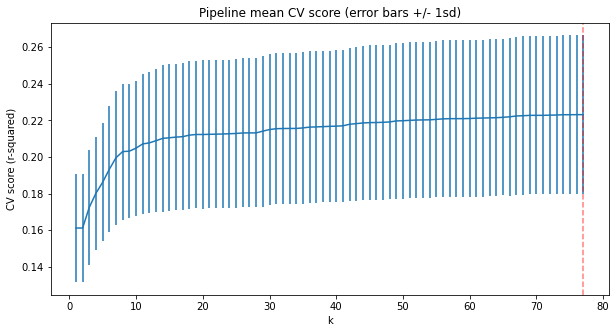

In [93]:
#Assign the value of k from the above dict of `best_params_` and assign it to `best_k`
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

The above suggests a good value for k is 77. There was an initial rapid increase with k, followed by a slow decline. Also noticeable is the variance of the results increase above k=77. If overfitting, expect greater swings in performance as different points move in and out of the train/test folds.

Stepping into the best model, shown below, start with the fitted grid search object, getting the best estimator, then the named step 'selectkbest', that has the get_support() method for a logical mask of the features selected.

In [94]:
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()

Similarly, instead of using the 'selectkbest' named step, access the named step for linear regression model and grab the model coefficients via its coef_ attribute:

In [95]:
#Get the linear model coefficients from `coef_` attribute and store in `coefs`, get matching feature names from column names
#of the dataframe, and display results as a pandas Series with `coefs` as values and `features` as index, sorting values in
#descending order
coefs = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
features = X_train.columns[selected]
pd.Series(coefs, index=features).sort_values(ascending=False)

country_US                        3.420634e+12
country_France                    2.607426e+12
country_Italy                     2.480091e+12
country_Spain                     1.525265e+12
country_Portugal                  1.422866e+12
                                      ...     
Over/above_avg.?_Above avg.      -1.306354e+12
Over/above_avg.?_0               -1.331426e+12
province_California              -2.051642e+12
winery_Others w. count < 120     -2.107132e+12
province_Others w. count <2000   -2.156247e+12
Length: 77, dtype: float64

Results suggest country_US is the biggest positive feature. Many of the countries for that matter have a weak yet positive relationship. The province_Others w. count <2000 is negatively associated with wine price. For example, if the wine was from a province that doesn't typically produce wine, then the wine price is cheaper.

Random Forest Model: A model works in a lot of cases. For regression, this is provided by sklearn's RandomForestRegressor class.

Time to stop the bad practice of repeatedly checking performance on the test split. Instead, go straight from defining the pipeline to assessing performance using cross-validation. cross_validate will perform the fitting as part of the process. This uses the default settings for the random forest to then proceed to investigate some different hyperparameters.

In [96]:
#Define a pipeline comprising the steps:
#SimpleImputer() with a strategy of 'median'
#StandardScaler(), and then RandomForestRegressor() with a random state of 47
RF_pipe = make_pipeline(SimpleImputer(strategy='median'),
    StandardScaler(), RandomForestRegressor(random_state=47))

In [97]:
#Fit and assess performance using cross-validation:
#Call `cross_validate` to estimate pipeline's performance. Pass it random forest pipe object, `X_train` and `y_train`,
#and get it to use 5-fold cross-validation
rf_default_cv_results = cross_validate(RF_pipe, X_train, y_train, cv=5)

In [98]:
rf_cv_scores = rf_default_cv_results['test_score']
rf_cv_scores

array([0.28666686, 0.36081336, 0.31812524, 0.21485918, 0.24961467])

In [99]:
np.mean(rf_cv_scores), np.std(rf_cv_scores)

(0.28601586166943876, 0.0510184703824665)

Hyperparameter search using GridSearchCV

Random forest has a number of hyperparameters that can be explored, however here you'll limit yourselves to exploring some different values for the number of trees. You'll try it with and without feature scaling, and try both the mean and median as strategies for imputing missing values.

In [100]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params = {'randomforestregressor__n_estimators': n_est,
        'standardscaler': [StandardScaler(), None],
        'simpleimputer__strategy': ['mean', 'median']}
grid_params

{'randomforestregressor__n_estimators': [10,
  12,
  16,
  20,
  26,
  33,
  42,
  54,
  69,
  88,
  112,
  143,
  183,
  233,
  297,
  379,
  483,
  615,
  784,
  1000],
 'standardscaler': [StandardScaler(), None],
 'simpleimputer__strategy': ['mean', 'median']}

In [101]:
#Call `GridSearchCV` with random forest pipeline, passing in above `grid_params`
#dict for parameters to evaluate, 5-fold cross-validation, and all available CPU cores (if desired)
rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [ ]:
#Now call the `GridSearchCV`'s `fit()` method with `X_train` and `y_train` as arguments
#to actually start the grid search. This may take a minute or two.
rf_grid_cv.fit(X_train, y_train)

In [ ]:
#Print the best params (`best_params_` attribute) from the grid search
rf_grid_cv.best_params_

It looks like imputing with the mean helps, as does scaling the features.

In [ ]:
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, cv=5)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores

In [ ]:
np.mean(rf_best_scores), np.std(rf_best_scores)

You've marginally improved upon the default CV results. Random forest has many more hyperparameters you could tune, but we won't dive into that here.

In [ ]:
#Plot a barplot of random forest's feature importances, assigning `feature_importances_` attribute of 
#`rf_grid_cv.best_estimator_.named_steps.randomforestregressor` to the name `imps` to create a pandas Series object of 
#feature importances, with the index given by the training data column names, sorting the values in descending order
plt.subplots(figsize=(18, 5))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');

The dominant features are:

- points, perhaps most obviously
- province_Burgundy - this indicates wine prices from this province are able to be determined as a result of it being produced there
- Over/above avg? Above avg. - this ties into the first one, points that were above average were a determinant in wine pricing

Final Model Selection:

Good to revisit the above model selection; more that could be done to explore possible hyperparameters. Also worthwhile to investigate removing least useful features. Gathering or calculating, and storing, features adds business cost and dependencies, so if features genuinely aren't needed they should be removed. Building a simpler model with fewer features can be easier to sell (or explain) to stakeholders. There seem to be 3 strong features here and so a model using only those would probably work well. However, to explore some different scenarios where other features vary, so keep the fuller model for now. The business is waiting for this model and the confidence to be much better than guessing with the average price.

There are two "somethings" in the best linear model and a best random forest model. Now to finally choose between them. Calculate the mean absolute error using cross-validation. Although cross-validate defaults to the  𝑅2  metric for scoring regression, specify the mean absolute error as an alternative via the scoring parameter.

In [ ]:
# 'neg_mean_absolute_error' uses the (negative of) the mean absolute error
lr_neg_mae = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [ ]:
lr_mae_mean = np.mean(-1 * lr_neg_mae['test_score'])
lr_mae_std = np.std(-1 * lr_neg_mae['test_score'])
lr_mae_mean, lr_mae_std

In [ ]:
mean_absolute_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))

**Random forest regression model performance**

In [ ]:
rf_neg_mae = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [ ]:
rf_mae_mean = np.mean(-1 * rf_neg_mae['test_score'])
rf_mae_std = np.std(-1 * rf_neg_mae['test_score'])
rf_mae_mean, rf_mae_std

In [ ]:
mean_absolute_error(y_test, rf_grid_cv.best_estimator_.predict(X_test))

Conclusion: The random forest model has a lower cross-validation mean absolute error by almost $2 of the nearest lowest. It also exhibits less variability. Verifying performance on the test set produces performance consistent with the cross-validation results.

Data quantity assessment:

Finally, to advise the business whether to undertake further data collection. Is more data useful? Often led to believe more data is always good, but gathering data invariably has a cost. Assess trade off by seeing how performance varies with differing data set sizes. The learning_curve function does this conveniently.

In [ ]:
fractions = [.2, .25, .3, .35, .4, .45, .5, .6, .75, .8, 1.0]
train_size, train_scores, test_scores = learning_curve(pipe, X_train, y_train, train_sizes=fractions)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

This shows that you seem to have plenty of data. There's an initial rapid improvement in model scores, but it essentially levelled off by around a sample size of 350-400.

Summary

Q: Write a summary of the work in this notebook. Capture the fact that you gained a baseline idea of performance by simply taking the average price and how well that did. Then highlight that you built a linear model and the features that found. Comment on the estimate of its performance from cross-validation and whether its performance on the test split was consistent with this estimate. Also highlight that a random forest regressor was tried, what preprocessing steps were found to be best, and again what its estimated performance via cross-validation was and whether its performance on the test set was consistent with that. State which model you have decided to use going forwards and why. This summary should provide a quick overview for someone wanting to know quickly why the given model was chosen for the next part of the business problem to help guide important business decisions.

A: When initially starting this unit, it felt like a trial by fire, however as I learned the difference between the X being attributes pertaining to house prices, Y being the actual price it is being compared to, and the difference in a test set and training, it started to slowly come together. The Random Forest Regression seemed to perform better relative to the linear regression, although it makes sense to always compare both for each business case rather than assuming that will always be the case.